In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
#store midi files as numpy arrays inside dict for easy iteration and look-up
!pip install mido
import os
import mido
import numpy as np

folder_path = 'gdrive/MyDrive/GOLDSMITHS/year 3/dandml/midi_pack'
midi_files = [f for f in os.listdir(folder_path)]
midi_list = []

for file in midi_files:
    sequence = np.zeros((8,8))
    midi = mido.MidiFile(f'{folder_path}/{file}')
    step = 0
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on':
                note = msg.note
                sequence[step%8][(note-4)%8] = 1
                step += 1
            elif msg.type == 'note_off':
                note = msg.note
                sequence[step%8][(note-4)%8] = 0
                step += 1
    midi_list.append(sequence)
print(len(midi_list))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.5 MB/s eta 0:00:00
496


In [3]:
y_train = []
x_train = []

for i, midi in enumerate(midi_list):
  if i % 2 == 0:
    x_train.append(midi)
  elif i % 2 == 1:
    y_train.append(midi)
print(len(x_train))
print(len(y_train))


248
248


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
test_cap = round((len(x_train) * 0.2))
print(test_cap)

x_test, y_test = x_train[0:test_cap], y_train[0:test_cap]
x_train, y_train = x_train[test_cap:], y_train[test_cap:]
print(len(x_train))
print(len(y_train))

50
198
198


In [7]:
import random
x_augment = []
y_augment = []
for arr in x_train:
  choice = random.randint(1, 3)
  if choice == 1:
    x_augment.append(np.flip(arr))
  elif choice == 2:
    x_augment.append(np.flip(arr, 1))
  elif choice == 3:
    x_augment.append(np.flip(arr, 0))
x_train = np.concatenate((x_train, x_augment))
for arr in y_train:
  choice = random.randint(1, 3)
  if choice == 1:
    y_augment.append(np.flip(arr))
  elif choice == 2:
    y_augment.append(np.flip(arr, 1))
  elif choice == 3:
    y_augment.append(np.flip(arr, 0))

y_train = np.concatenate((y_train, y_augment))


In [8]:
from tensorflow.keras import regularizers

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(4, 4), activation='linear', input_shape=(8, 8, 1)))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='linear', kernel_regularizer='l2'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='linear', kernel_regularizer='l2'))
model.add(layers.Dropout(0.5))
model.add(layers.Reshape((8,8)))
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

x_train = np.array(x_train)
y_train = np.array(y_train)

K = 2
num_val_samples = len(x_train) // K
num_epochs = 60
all_acc_histories = []
all_loss_histories = []

for i in range(K):
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    x_val = x_train[a : b]
    y_val = y_train[a : b]
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([x_train[:a], x_train[b:]])
    partial_train_targets = np.concatenate([y_train[:a], y_train[b:]])
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(x_val, y_val),
        epochs=num_epochs, batch_size=8)

    accuracy_history = history.history['val_mae']
    loss_history = history.history['loss']

    all_loss_histories.append(loss_history)
    all_acc_histories.append(loss_history)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 32)          544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 32)          0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

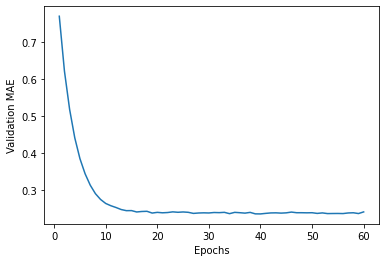

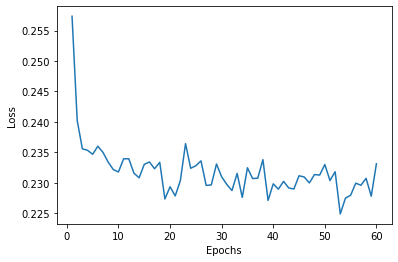

2/2 [==============================] - 0s 17ms/step - loss: 0.2023 - mae: 0.3151
loss — -> 0.2023424357175827
mae — -> 0.3150600790977478


In [9]:
import matplotlib.pyplot as plt
average_acc_history = np.array(all_acc_histories).mean(axis=0)
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

average_loss_history = np.array(all_loss_histories).mean(axis=0)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

x_test = np.array(x_test)
y_test = np.array(y_test)

result = model.evaluate(x_test, y_test)
for i in range(len(result)):
    print(f'{model.metrics_names[i]} — -> {result[i]}')

In [ ]:
from keras.models import load_model
from google.colab import files

model.save('model.h5')
files.download('model.h5')

In [23]:
#using the model to create predictions for the drum model

arr = [[[1., 0., 0., 0., 0., 1., 0., 0.],
  [0., 0., 1., 0., 0., 0., 1., 0.],
  [0., 0., 0., 0., 0., 1., 0., 0.,],
  [0., 0., 0., 0., 0., 0., 1., 0.],
  [0., 0., 0., 0., 0., 1., 0., 0.],
  [0., 0., 0., 0., 0., 0., 0., 1.],
  [0., 0., 0., 0., 0., 1., 0., 0.],
  [0., 0., 0., 0., 0., 0., 0., 1.]]]

myarr = np.array(arr).astype(float)
pred = model.predict(myarr.reshape(1,8,8))

min_val = np.min(pred)
max_val = np.max(pred)
range_val = max_val - min_val
scaled_arr = (pred - min_val) / range_val
rounded_arr = np.round(scaled_arr)
print(rounded_arr.astype(bool))

1/1 [==============================] - 0s 42ms/step
[[[ True False  True False False False False False]
  [ True False  True False False False False False]
  [ True False  True False False False False False]
  [ True False  True False False False False False]
  [ True False  True False False False False False]
  [ True False  True False False False False False]
  [ True False  True False False False False False]
  [ True False  True False False False False False]]]
